### Credit Risk analysis ###
https://www.kaggle.com/competitions/home-credit-default-risk ###


general points:
- for some reason, kernel keeps ram-crashing whenever I try to replace some values using .loc. have to downscale dataset.

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [57]:
time0 = time.time()

# for some reason i cannot properly read column description file... will have to open it locally

#ss = pd.read_csv('../input/home-credit-default-risk/sample_submission.csv')
#display(ss.head(), ss.shape)

df = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
#df = df.sample(150000)
display(df.shape, df.head(), time.time()-time0, sys.getsizeof(df)/1048576)

(307511, 122)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

3.904257297515869

536.6916284561157

In [58]:
df.columns = [col.lower() for col in list(df.columns)]
display(df.head(), df.target.mean())

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

0.08072881945686496

In [59]:
# I will process features in batches and will keep adding them as i go along
# I want to run EDA first to understand what those features are 

num_features = ['cnt_children', 'amt_income_total', 'amt_credit', 'amt_annuity', 'amt_goods_price', 
               'region_population_relative', 'days_birth', 'days_employed', 'days_registration', 'days_id_publish', 
               'own_car_age', 'cnt_fam_members', 'ext_source_1', 'ext_source_2', 'ext_source_3']
cat_features = ['name_contract_type', 'code_gender', 'flag_own_car', 'flag_own_realty', 'name_type_suite', 
               'name_income_type', 'name_education_type', 'name_family_status', 'name_housing_type', 'occupation_type']
bin_features = ['flag_mobil', 'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email']

df = df[['sk_id_curr', 'target']+num_features+cat_features+bin_features]
gc.collect()
display(df.shape, df.head(), df.info(), sys.getsizeof(df)/1048576)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   sk_id_curr                  307511 non-null  int64  
 1   target                      307511 non-null  int64  
 2   cnt_children                307511 non-null  int64  
 3   amt_income_total            307511 non-null  float64
 4   amt_credit                  307511 non-null  float64
 5   amt_annuity                 307499 non-null  float64
 6   amt_goods_price             307233 non-null  float64
 7   region_population_relative  307511 non-null  float64
 8   days_birth                  307511 non-null  int64  
 9   days_employed               307511 non-null  int64  
 10  days_registration           307511 non-null  float64
 11  days_id_publish             307511 non-null  int64  
 12  own_car_age                 104582 non-null  float64
 13  cnt_fam_member

(307511, 33)

,sk_id_curr,target,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,cnt_fam_members,ext_source_1,ext_source_2,ext_source_3,name_contract_type,code_gender,flag_own_car,flag_own_realty,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,occupation_type,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,NaN,1.0,0.083037,0.262949,0.139376,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,1,1,0,1,1,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,NaN,2.0,0.311267,0.622246,NaN,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,1,1,0,1,1,0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.0,1.0,NaN,0.555912,0.729567,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,1,1,1,1,1,0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,NaN,2.0,NaN,0.650442,NaN,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,1,1,0,1,0,0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,NaN,1.0,NaN,0.322738,NaN,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,1,1,0,1,0,0


None

246.71505069732666

In [60]:
# some basic cleaning

#df.code_gender = (df.code_gender=='M').astype(int)
#df.flag_own_car = (df.flag_own_car=='Y').astype(int)
display(sys.getsizeof(df))

dftypes = df.dtypes
o_features = list((dftypes[dftypes=='O']).index)
for col in o_features:
    df[col] = df[col].astype('category')
display(df.dtypes, sys.getsizeof(df)/1048576, df.head())

258699481

sk_id_curr                       int64
target                           int64
cnt_children                     int64
amt_income_total               float64
amt_credit                     float64
amt_annuity                    float64
amt_goods_price                float64
region_population_relative     float64
days_birth                       int64
days_employed                    int64
days_registration              float64
days_id_publish                  int64
own_car_age                    float64
cnt_fam_members                float64
ext_source_1                   float64
ext_source_2                   float64
ext_source_3                   float64
name_contract_type            category
code_gender                   category
flag_own_car                  category
flag_own_realty               category
name_type_suite               category
name_income_type              category
name_education_type           category
name_family_status            category
name_housing_type        

56.89948749542236

,sk_id_curr,target,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,cnt_fam_members,ext_source_1,ext_source_2,ext_source_3,name_contract_type,code_gender,flag_own_car,flag_own_realty,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,occupation_type,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,NaN,1.0,0.083037,0.262949,0.139376,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,1,1,0,1,1,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,NaN,2.0,0.311267,0.622246,NaN,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,1,1,0,1,1,0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.0,1.0,NaN,0.555912,0.729567,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,1,1,1,1,1,0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,NaN,2.0,NaN,0.650442,NaN,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,1,1,0,1,0,0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,NaN,1.0,NaN,0.322738,NaN,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,1,1,0,1,0,0


### EDA 

EDA.1. What do people take loans for? Car purchases? Lets explore loan amounts. Probably this is outside of the US, so it is hard to tell what the price scale is...

,amt_credit,amt_goods_price
count,3.075110e+05,3.072330e+05
mean,5.990260e+05,5.383962e+05
std,4.024908e+05,3.694465e+05
min,4.500000e+04,4.050000e+04
25%,2.700000e+05,2.385000e+05
50%,5.135310e+05,4.500000e+05
75%,8.086500e+05,6.795000e+05
max,4.050000e+06,4.050000e+06


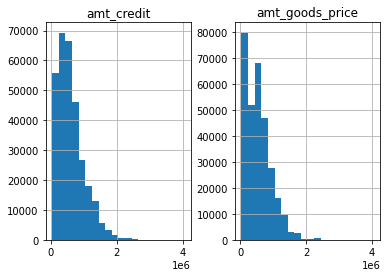

In [61]:
display(df[['amt_credit', 'amt_goods_price']].describe())
df[['amt_credit', 'amt_goods_price']].hist(bins=20)
df['goods_to_loan'] = df.amt_goods_price/df.amt_credit

In [62]:
df.name_contract_type.value_counts()

Cash loans         278232
Revolving loans     29279
Name: name_contract_type, dtype: int64

Given average price around 300,000 and car loan as a type, this must be currency, different from the US dollar.

## EDA.2. Can people afford the loan given their income?

count    307511.000000
mean          3.957570
std           2.689728
min           0.004808
25%           2.018667
50%           3.265067
75%           5.159880
max          84.736842
Name: dti, dtype: float64

<AxesSubplot:>

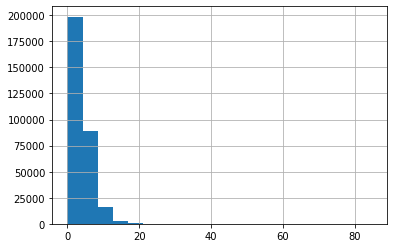

count    307499.000000
mean          0.053695
std           0.022481
min           0.022073
25%           0.036900
50%           0.050000
75%           0.064043
max           0.124430
Name: malr, dtype: float64

<AxesSubplot:>

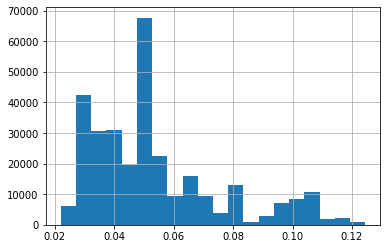

In [63]:
# lets compute debt to income ratio

df['dti'] = df.amt_credit/df.amt_income_total
display(df.dti.describe(), df.dti.hist(bins=20))
plt.show()

#sns.barplot(y='dti', x='target', data=df)
#plt.show()
# no clear pattern. we would expect this, otherwise lending behavior of a lender would be unwise.

df['malr'] = df.amt_annuity/df.amt_credit
display(df.malr.describe(), df.malr.hist(bins=20))
median_annuity_to_loan = df['malr'].median()

# this company seems to be lending aggressively: average loan will probably be repayed in 2-4 years, 
# while loan amount is usually above total income.

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: days_employed, dtype: float64

16391

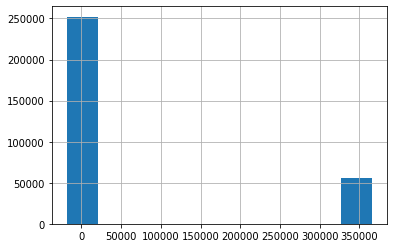

In [64]:
display(df.days_employed.describe())
df.days_employed.hist()
gc.collect()

In [65]:
# transform days features to be more intuitive:

df['years_birth'] = -df['days_birth']/365
df['years_employed'] = -df['days_employed']/365
df.loc[df.years_employed<0, 'years_employed']=-1
df['years_registration'] = -df['days_registration']/365
df['years_id_publish'] = -df['days_id_publish']/365

display(df[['years_birth', 'years_employed', 'years_registration', 'years_id_publish']].describe())
df.drop(columns = ['days_birth', 'days_employed', 'days_registration', 'days_id_publish'], inplace=True)
gc.collect()

,years_birth,years_employed,years_registration,years_id_publish
count,307511.000000,307511.000000,307511.000000,307511.000000
mean,43.936973,5.175677,13.660604,8.203294
std,11.956133,6.482916,9.651743,4.135481
min,20.517808,-1.000000,-0.000000,0.000000
25%,34.008219,0.791781,5.506849,4.712329
50%,43.150685,3.323288,12.339726,8.915068
75%,53.923288,7.561644,20.491781,11.778082
max,69.120548,49.073973,67.594521,19.717808


3677

In [66]:
display(df.own_car_age.describe())
# i guess missing values are mix of ppl without a car and ppl who did not provide any info on their car
# if i had a good car, i would give this info to a loan agency to decrease my interest rate
# so i guess those are either crappy cars or no cars
# I encode them as 30-years old cars
df.loc[df.own_car_age.isnull(), 'own_car_age']=30
display(df.own_car_age.describe())
display(df.head())

count    104582.000000
mean         12.061091
std          11.944812
min           0.000000
25%           5.000000
50%           9.000000
75%          15.000000
max          91.000000
Name: own_car_age, dtype: float64

count    307511.000000
mean         23.899122
std          10.988454
min           0.000000
25%          15.000000
50%          30.000000
75%          30.000000
max          91.000000
Name: own_car_age, dtype: float64

,sk_id_curr,target,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,own_car_age,cnt_fam_members,ext_source_1,ext_source_2,ext_source_3,name_contract_type,code_gender,flag_own_car,flag_own_realty,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,occupation_type,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,goods_to_loan,dti,malr,years_birth,years_employed,years_registration,years_id_publish
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,30.0,1.0,0.083037,0.262949,0.139376,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,1,1,0,1,1,0,0.863262,2.007889,0.060749,25.920548,1.745205,9.994521,5.808219
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,30.0,2.0,0.311267,0.622246,NaN,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,1,1,0,1,1,0,0.873211,4.790750,0.027598,45.931507,3.254795,3.249315,0.797260
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,26.0,1.0,NaN,0.555912,0.729567,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,1,1,1,1,1,0,1.000000,2.000000,0.050000,52.180822,0.616438,11.671233,6.934247
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,30.0,2.0,NaN,0.650442,NaN,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,1,1,0,1,0,0,0.949845,2.316167,0.094941,52.068493,8.326027,26.939726,6.676712
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,30.0,1.0,NaN,0.322738,NaN,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,1,1,0,1,0,0,1.000000,4.222222,0.042623,54.608219,8.323288,11.810959,9.473973


### Prepare data for modeling

In [67]:
df.drop(columns = ['sk_id_curr'],inplace=True)
display(df.count())

target                        307511
cnt_children                  307511
amt_income_total              307511
amt_credit                    307511
amt_annuity                   307499
amt_goods_price               307233
region_population_relative    307511
own_car_age                   307511
cnt_fam_members               307509
ext_source_1                  134133
ext_source_2                  306851
ext_source_3                  246546
name_contract_type            307511
code_gender                   307511
flag_own_car                  307511
flag_own_realty               307511
name_type_suite               306219
name_income_type              307511
name_education_type           307511
name_family_status            307511
name_housing_type             307511
occupation_type               211120
flag_mobil                    307511
flag_emp_phone                307511
flag_work_phone               307511
flag_cont_mobile              307511
flag_phone                    307511
f

In [68]:
# fill few missing values for annuity and goods price
df.loc[df.amt_annuity.isnull(), 'amt_annuity'] = median_annuity_to_loan*df.amt_credit
df.loc[df.amt_goods_price.isnull(), 'amt_goods_price'] = df.amt_credit
df.loc[df.cnt_fam_members.isnull(), 'cnt_fam_members'] = 1

In [69]:
# train-test split

test_size = 0.1
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))

train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
display(train.shape, test.shape, train.head(3), test.head(3), train.count())

(276760, 35)

(30751, 35)

,target,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,own_car_age,cnt_fam_members,ext_source_1,ext_source_2,ext_source_3,name_contract_type,code_gender,flag_own_car,flag_own_realty,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,occupation_type,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,goods_to_loan,dti,malr,years_birth,years_employed,years_registration,years_id_publish
0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,30.0,1.0,0.083037,0.262949,0.139376,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,1,1,0,1,1,0,0.863262,2.007889,0.060749,25.920548,1.745205,9.994521,5.808219
1,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,30.0,2.0,0.311267,0.622246,NaN,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,1,1,0,1,1,0,0.873211,4.790750,0.027598,45.931507,3.254795,3.249315,0.797260
2,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,26.0,1.0,NaN,0.555912,0.729567,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,1,1,1,1,1,0,1.000000,2.000000,0.050000,52.180822,0.616438,11.671233,6.934247


,target,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,own_car_age,cnt_fam_members,ext_source_1,ext_source_2,ext_source_3,name_contract_type,code_gender,flag_own_car,flag_own_realty,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,occupation_type,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,goods_to_loan,dti,malr,years_birth,years_employed,years_registration,years_id_publish
182919,0,0,112500.0,472500.0,12591.0,472500.0,0.028663,0.0,2.0,NaN,0.280769,0.291097,Cash loans,F,Y,N,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,NaN,1,1,0,1,0,0,1.000000,4.2000,0.026648,51.673973,30.917808,18.884932,6.575342
239578,0,0,90000.0,301896.0,22702.5,252000.0,0.010643,30.0,2.0,NaN,0.583480,0.855524,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,1,1,0,1,0,0,0.834725,3.3544,0.075200,51.202740,26.687671,26.660274,5.947945
281000,0,1,135000.0,540000.0,27000.0,540000.0,0.003069,30.0,3.0,0.233025,0.634764,0.520898,Revolving loans,F,N,Y,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,Accountants,1,1,0,1,0,0,1.000000,4.0000,0.050000,31.553425,7.873973,14.517808,9.290411


target                        276760
cnt_children                  276760
amt_income_total              276760
amt_credit                    276760
amt_annuity                   276760
amt_goods_price               276760
region_population_relative    276760
own_car_age                   276760
cnt_fam_members               276760
ext_source_1                  120746
ext_source_2                  276175
ext_source_3                  221938
name_contract_type            276760
code_gender                   276760
flag_own_car                  276760
flag_own_realty               276760
name_type_suite               275597
name_income_type              276760
name_education_type           276760
name_family_status            276760
name_housing_type             276760
occupation_type               190009
flag_mobil                    276760
flag_emp_phone                276760
flag_work_phone               276760
flag_cont_mobile              276760
flag_phone                    276760
f

In [70]:
median_annuity_to_loan = train.malr.median()
df.loc[df.amt_annuity.isnull(), 'amt_annuity'] = median_annuity_to_loan*df.amt_credit

col_mean = ['ext_source_1', 'ext_source_2', 'ext_source_3', 'malr', 'goods_to_loan']
for col in col_mean:
    train[col]= train[col].fillna(train[col].mean())
    test[col]= test[col].fillna(train[col].mean())
    
col_mode = ['name_type_suite', 'occupation_type']
for col in col_mode:
    train[col]= train[col].fillna(train[col].mode()[0])
    test[col]= test[col].fillna(train[col].mode()[0])

display(train.count(), test.count())

target                        276760
cnt_children                  276760
amt_income_total              276760
amt_credit                    276760
amt_annuity                   276760
amt_goods_price               276760
region_population_relative    276760
own_car_age                   276760
cnt_fam_members               276760
ext_source_1                  276760
ext_source_2                  276760
ext_source_3                  276760
name_contract_type            276760
code_gender                   276760
flag_own_car                  276760
flag_own_realty               276760
name_type_suite               276760
name_income_type              276760
name_education_type           276760
name_family_status            276760
name_housing_type             276760
occupation_type               276760
flag_mobil                    276760
flag_emp_phone                276760
flag_work_phone               276760
flag_cont_mobile              276760
flag_phone                    276760
f

target                        30751
cnt_children                  30751
amt_income_total              30751
amt_credit                    30751
amt_annuity                   30751
amt_goods_price               30751
region_population_relative    30751
own_car_age                   30751
cnt_fam_members               30751
ext_source_1                  30751
ext_source_2                  30751
ext_source_3                  30751
name_contract_type            30751
code_gender                   30751
flag_own_car                  30751
flag_own_realty               30751
name_type_suite               30751
name_income_type              30751
name_education_type           30751
name_family_status            30751
name_housing_type             30751
occupation_type               30751
flag_mobil                    30751
flag_emp_phone                30751
flag_work_phone               30751
flag_cont_mobile              30751
flag_phone                    30751
flag_email                  

In [82]:
X_train = train.copy()
y_train = X_train.pop('target')

X_test = test.copy()
y_test = X_test.pop('target')

display(X_train.shape, y_train.shape, X_test.shape)

(276760, 34)

(276760,)

(30751, 34)

In [83]:
# do ohe for unencdoded cat features:

time1 = time.time()

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore"), cat_features+bin_features)],
    remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)



Number of features before transaformation:  (276760, 34)
time to do feature proprocessing:  1.5281293392181396
Number of features after transaformation:  (276760, 89)
